In [13]:
# Import Libraries and Modules
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
warnings.filterwarnings('ignore')

In [14]:
# Load data from an Excel file 
path = '../data/excel/LAEI2013_MajorRoads_EmissionsbyLink_2013.xlsx'
df = pd.read_excel(path)

## Data Cleaning

In [15]:
# Create a copy for further processing
df_proc = df.copy()
df_proc.columns

Index(['GridId', 'Toid', 'GRID_ExactCut_ID', 'Location_ExactCut',
       'BoroughName_ExactCut', 'Lts', 'Length (m)', 'Emissions', 'Year',
       'Pollutant', 'Emissions Unit', 'Motorcycle', 'Taxi', 'Car',
       'BusAndCoach', 'Lgv', 'Rigid', 'Artic', 'Rigid2Axle', 'Rigid3Axle',
       'Rigid4Axle', 'Artic3Axle', 'Artic5Axle', 'Artic6Axle', 'PetrolCar',
       'DieselCar', 'PetrolLgv', 'DieselLgv', 'LtBus', 'Coach', 'ElectricCar',
       'ElectricLgv'],
      dtype='object')

In [16]:
# Sum up emissions by vehicle types
column_names = list(df_proc.columns[11:])
df_proc['Link_Emissions'] = df_proc[column_names[:]].sum(axis=1)
df_proc.drop(column_names, axis=1, inplace=True)

In [17]:
# Drop unused columns
df_proc.drop(['Length (m)', 
              'BoroughName_ExactCut',
              'GRID_ExactCut_ID',
              'Emissions Unit', 
              'GridId',
              'Year', 
              'Lts',
              'Emissions',
              ], axis=1, inplace=True)

In [18]:
# Create Pivot table to have Emission types as columns
df_proc = df_proc.pivot_table(index=['Toid', 'Location_ExactCut'], columns=['Pollutant'], values=['Link_Emissions'])
df_proc.columns = df_proc.columns.droplevel(0)
df_proc = df_proc.reset_index()

In [19]:
# Convert 0 values to NaN and drop rows containing NaN vals
df_proc = df_proc.replace(0,np.nan)
df_proc = df_proc.dropna()

## Preprocessing Data

#### Step 1: Removing outliers

<Axes: xlabel='Pollutant'>

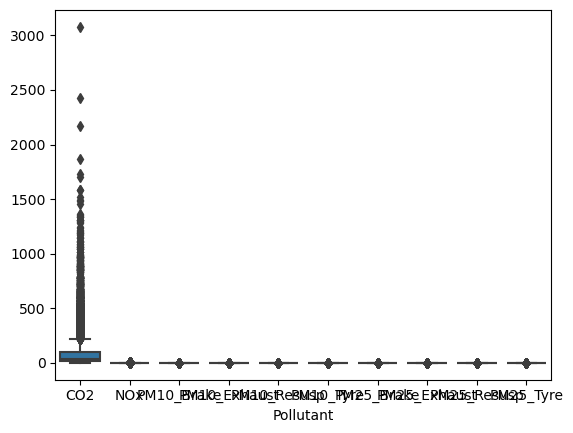

In [20]:
# Check for outliers
sns.boxplot(data=df_proc[df_proc.columns[2:]])

In [21]:
# Remove the outliers
def removeOutliers(data, col):
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
 
    print("IQR value for column %s is: %s" % (col, IQR))
    global outlier_free_list
    global filtered_data
 
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    outlier_free_list = [x for x in data[col] if (
        (x > lower_range) & (x < upper_range))]
    filtered_data = data.loc[data[col].isin(outlier_free_list)]
 
 
for i in df_proc.columns[2:]:
      if i == df_proc.columns[2:][0]:
          removeOutliers(df_proc, i)
      else:
          removeOutliers(filtered_data, i)

df_proc = filtered_data

IQR value for column CO2 is: 82.48738326702994
IQR value for column NOx is: 0.22347498762928333
IQR value for column PM10_Brake is: 0.01259800102549173
IQR value for column PM10_Exhaust is: 0.002865684809606478
IQR value for column PM10_Resusp is: 0.0071323150907462406
IQR value for column PM10_Tyre is: 0.0019462284184723598
IQR value for column PM25_Brake is: 0.003526826193620073
IQR value for column PM25_Exhaust is: 0.0021017948372555493
IQR value for column PM25_Resusp is: 0.00020665607822040438
IQR value for column PM25_Tyre is: 0.001120175407490174


In [22]:
# Extract Location column to separate variable and delete Borough and Toid columns
y = df_proc['Location_ExactCut']
df_proc.drop(['Location_ExactCut', 'Toid'], axis=1, inplace=True)

In [23]:
df_proc.columns

Index(['CO2', 'NOx', 'PM10_Brake', 'PM10_Exhaust', 'PM10_Resusp', 'PM10_Tyre',
       'PM25_Brake', 'PM25_Exhaust', 'PM25_Resusp', 'PM25_Tyre'],
      dtype='object', name='Pollutant')

In [24]:
df_proc.describe()

Pollutant,CO2,NOx,PM10_Brake,PM10_Exhaust,PM10_Resusp,PM10_Tyre,PM25_Brake,PM25_Exhaust,PM25_Resusp,PM25_Tyre
count,23034.000000,23034.000000,23034.000000,2.303400e+04,2.303400e+04,2.303400e+04,23034.000000,2.303400e+04,2.303400e+04,2.303400e+04
mean,27.968708,0.100813,0.006369,1.625085e-03,4.354371e-03,1.262157e-03,0.002535,1.543831e-03,1.599943e-04,8.835096e-04
std,23.598245,0.083656,0.005281,1.360675e-03,3.694162e-03,1.082302e-03,0.002102,1.292641e-03,1.350061e-04,7.576116e-04
min,0.010768,0.000026,0.000003,6.581579e-07,4.368107e-07,5.819185e-07,0.000001,6.252500e-07,1.747243e-08,4.073430e-07
25%,9.010329,0.033062,0.002054,5.155562e-04,1.377592e-03,3.844268e-04,0.000818,4.897784e-04,5.087142e-05,2.690987e-04
50%,21.260131,0.077392,0.004831,1.237917e-03,3.245869e-03,9.279665e-04,0.001923,1.176021e-03,1.198879e-04,6.495765e-04
75%,41.888591,0.151054,0.009618,2.451426e-03,6.469818e-03,1.911668e-03,0.003828,2.328855e-03,2.380699e-04,1.338167e-03
max,189.077286,0.531303,0.022345,6.075813e-03,1.575287e-02,4.389652e-03,0.008892,5.772023e-03,5.705061e-04,3.072756e-03


#### Step 2: Scaling Data

In [25]:
# Scaling the data
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df_proc)

## PCA model for dimensionality Reduction and Data Exploration

#### Step 1: Determine the optimal number of components

Text(0.5, 1.0, 'Scree Plot')

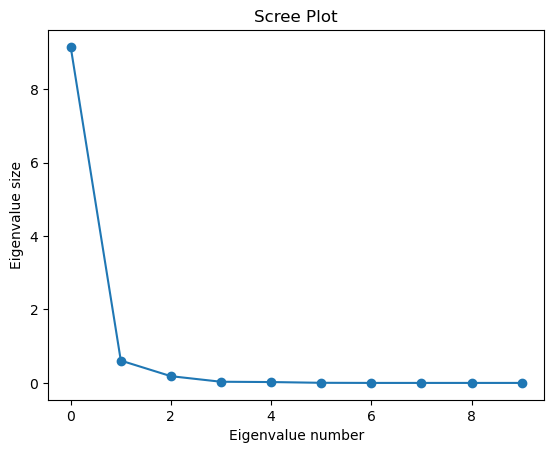

In [26]:
# Generate Scree Plot
pca = PCA()
x = pca.fit_transform(df_scaled)
explained_variance = pca.explained_variance_ratio_
plt.plot(pca.explained_variance_, marker='o')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")

Text(0.5, 1.0, 'PCA Components vs. Explained Variance Ratio')

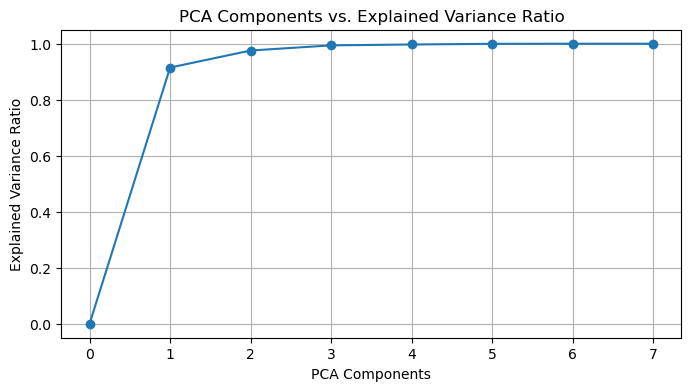

In [27]:
# Generate models
nums = np.arange(8)
var_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(df_scaled)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))
  
# Plot PCA Components vs. Explained Variance Ratio
plt.figure(figsize=(8,4))
plt.grid()
plt.plot(nums,var_ratio,marker='o')
plt.xlabel('PCA Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Components vs. Explained Variance Ratio')

#### Step 2: Apply PCA

#### PCA with 2 prinicpal components: creating the model and evaluating the results

In [28]:
# Create two component PCA
pca = PCA(n_components=2)
x = pca.fit_transform(df_scaled)
print(sum(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)

# Generate loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=df_proc.columns)
print(f'Loadings:\n{loadings_df}\n===============================')

# Create DataFrame with principal components and target (Borough)
PCA_df = pd.DataFrame(data = x)
PCA_df = PCA_df.reset_index(drop=True)
y = y.reset_index(drop=True)
df_final = pd.concat([PCA_df, y], axis = 1)
df_final.columns = ['PC1', 'PC2', 'London Area']

0.9757371880457728
[0.91487449 0.0608627 ]
Loadings:
                   PC1       PC2
Pollutant                       
CO2           0.971019 -0.068685
NOx           0.945110  0.248223
PM10_Brake    0.983492 -0.136752
PM10_Exhaust  0.977838 -0.112767
PM10_Resusp   0.893155  0.437511
PM10_Tyre     0.964011 -0.233401
PM25_Brake    0.983492 -0.136752
PM25_Exhaust  0.977838 -0.112767
PM25_Resusp   0.899900  0.423223
PM25_Tyre     0.964011 -0.233401


#### PCA with 2 prinicpal components: visualise results

Text(0.5, 1.0, 'PC1 vs. PC2')

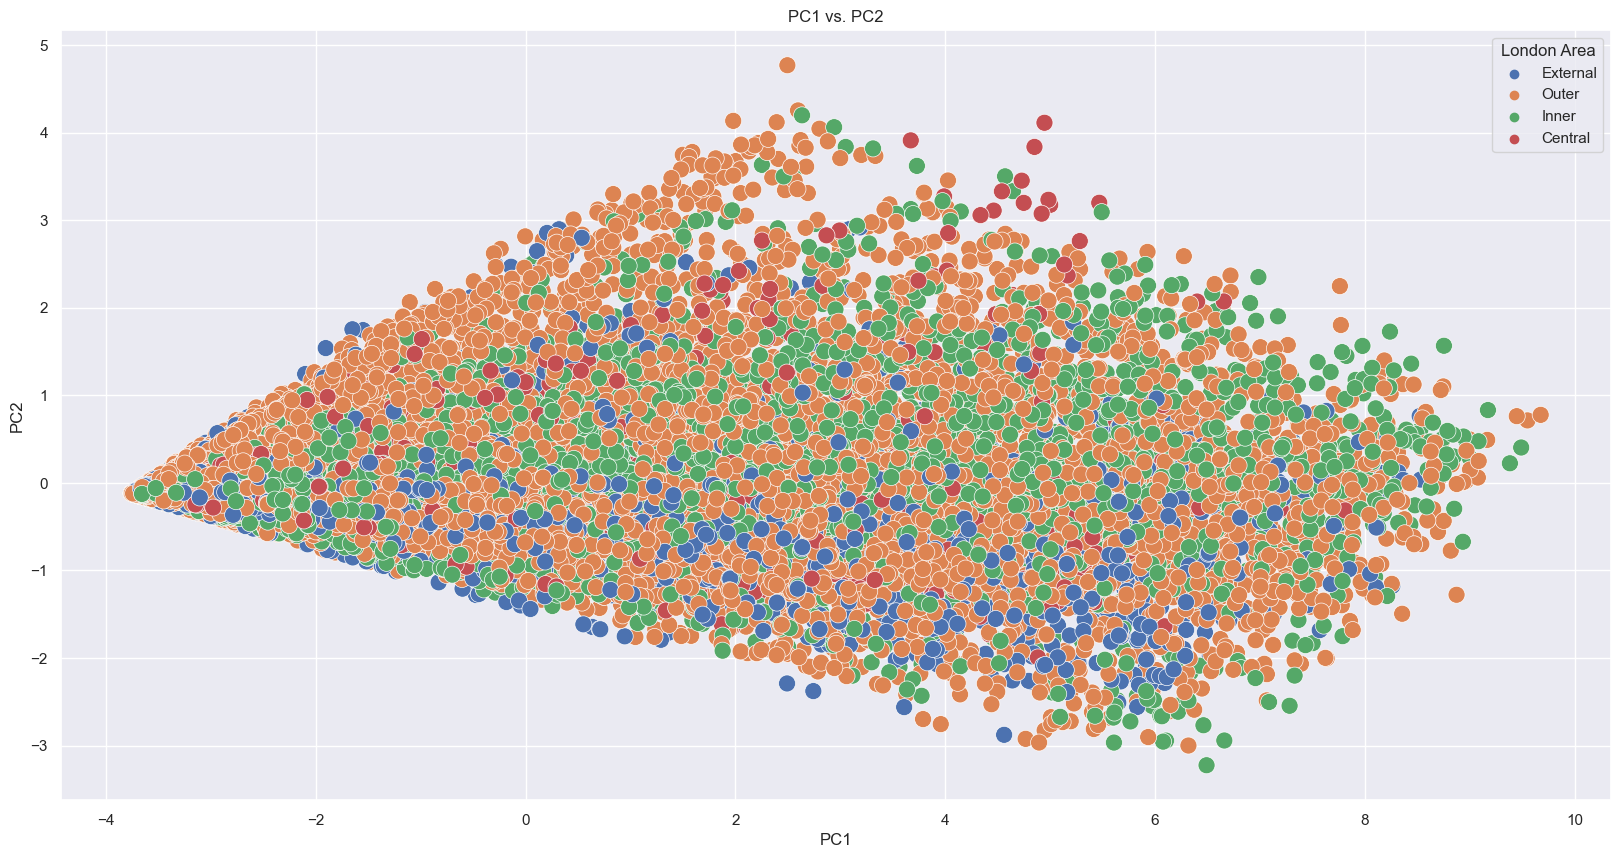

In [29]:
# 2D PCA Plot
sns.set(font_scale=2.0)
sns.color_palette("tab10")
sns.set_theme(rc={'figure.figsize':(20,10)})
ax = sns.scatterplot(data=df_final, x='PC1', y='PC2', hue='London Area')
ax.collections[0].set_sizes([150]) 
plt.title("PC1 vs. PC2")